# Spark Clustering

In this section we will create clusters based on the top 150 hotels in the top 40 check-in dates, by Discount Code.

At this point, we will use only PySpark as a Spark usage.

## *** Spark Init ***

First, we will initialize the Spark Context in order to work with it.

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

spark = SparkSession.builder \
            .master('local') \
            .appName('hotels') \
            .getOrCreate()
            
sc = spark.sparkContext 

## *** Data Manipulation ***

Now, after Spark Context is initialized, we can start handling the data itself.

First, by reading the data out of the csv file. The file contains all the data about the hotels.
Then, Taking only the top 150 hotels, counted by apperance in the data file.

In [51]:
def mapByHotelName(row):
    key = row['Hotel Name']
    val = 1
    return (key,val)

def reduceByCount(val1, val2):
    return (val1 + val2)

hotels_num = 150

hotels_rdd = spark.read.csv('../input/Hotels_Data_Changed.csv',header=True).rdd
hotel_names_top150 = hotels_rdd \
            .map(mapByHotelName) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(hotels_num)
            
hotel_names_keys = sc.parallelize(hotel_names_top150).keys().collect()
            
hotels_top = hotels_rdd.filter(lambda x: x['Hotel Name'] in hotel_names_keys)

### *** Top 150 hotels ***

In [54]:
for index,hotel in enumerate(hotel_names_top150):
    print (index+1, hotel[0],hotel[1])

1 Newark Liberty International Airport Marriott 5346
2 Hilton Garden Inn Times Square 4892
3 Residence Inn Newark Elizabeth Liberty International Airport 4314
4 Westin New York at Times Square 3792
5 Loews Regency New York Hotel 3617
6 Viceroy New York 3565
7 Four Seasons Hotel New York 3243
8 Langham Place New York Fifth Avenue 3203
9 The Carlyle A Rosewood Hotel 3078
10 DoubleTree by Hilton Metropolitan - New York City 2866
11 Magnuson Convention Center Hotel 2862
12 Hilton Garden Inn New York West 35th Street 2822
13 Hilton Garden Inn New York-Times Square Central 2772
14 Conrad New York 2677
15 Wyndham Garden Brooklyn Sunset Park 2599
16 Hilton Newark Airport 2524
17 Omni Berkshire Place 2358
18 Hilton Times Square 2273
19 Park Hyatt New York 2226
20 Homewood Suites by Hilton NY Midtown Manhattan Times Square 2211
21 Grand Hyatt New York 2165
22 The Plaza Hotel 2149
23 Quality Inn Woodside 2140
24 Hyatt Union Square New York 2114
25 Le Parker Meridien New York 2109
26 The New York 

## *** Top 40 dates ***

Now we will get the top 40 check-in dates that are found in the top 150 hotels (The top 40 dates, that we found in the list of the top 150 hotels).

In [63]:
def mapByCheckinDate(row):
    key = row['Checkin Date']
    val = 1
    return (key,val)

checkin_date_num = 40

checkin_top = hotels_top \
            .map(mapByCheckinDate) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(checkin_date_num)

checkin_top_keys = sc.parallelize(checkin_top).keys().collect()
checkin_top_keys.sort()
            
top_hotels_in_date = hotels_top.filter(lambda x: x['Checkin Date'] in checkin_top_keys) \
                        .sortBy(lambda x: x['Discount Code']) \
                        .sortBy(lambda x: x['Hotel Name']) \
                        .sortBy(lambda x: x['Checkin Date'])

### *** Top 40 dates of the top 150 hotels ***

In [59]:
for index,date in enumerate(checkin_top):
    print(index+1,date[0],date[1])

1 2015-08-12 1765
2 2015-08-13 1210
3 2015-08-19 1883
4 2015-08-26 1559
5 2015-08-27 1239
6 2015-08-28 1251
7 2015-09-09 1616
8 2015-09-10 1623
9 2015-09-11 1332
10 2015-09-16 1407
11 2015-09-17 1402
12 2015-09-18 1326
13 2015-09-30 1464
14 2015-10-01 1373
15 2015-10-02 1280
16 2015-10-07 1257
17 2015-10-14 1887
18 2015-10-15 1473
19 2015-10-16 1309
20 2015-10-21 1817
21 2015-10-22 1662
22 2015-10-27 1227
23 2015-10-28 1861
24 2015-10-29 1623
25 2015-10-30 1412
26 2015-11-03 1215
27 2015-11-04 1885
28 2015-11-05 1684
29 2015-11-06 1808
30 2015-11-07 1256
31 2015-11-10 1548
32 2015-11-11 2302
33 2015-11-12 1649
34 2015-11-13 1547
35 2015-11-18 1582
36 2015-11-21 1469
37 2015-11-25 1175
38 2015-11-26 1356
39 2015-11-27 1306
40 2015-11-28 1383


## *** Prepare for cluster ***

Create the matrix with the values that will fill the missing holes.

Based on our data we might have hotels that got no data for spacific check-in dates.

In [71]:
def createAllKeys(hotels,dates,codes):
    names_keys = sc.parallelize(hotels)
    dates_keys = sc.parallelize(dates)
    codes_keys = sc.parallelize(codes)
    return names_keys.cartesian(dates_keys.cartesian(codes_keys)).map(lambda x: (x[0], x[1][0], x[1][1]))

hotels_date_price_missing_data = createAllKeys(hotel_names_keys,checkin_top_keys,['1','2','3','4']).map(lambda x: (x, -1))

## *** Structure the data ***

Now, we build the data in the wanted structure based on the hotels and the dates that selected before

The discount code added to the structure becaues there are 4 different values, and we are going to process the data based on it. 

In [72]:
def mapHotelDatesDiscountCode(row):
    key = (row['Hotel Name'],row['Checkin Date'],row['Discount Code'])
    val = float(row['Discount Price'])
    return (key,val)


hotels_date_price = \
        top_hotels_in_date \
                .map(mapHotelDatesDiscountCode)

## *** Data merge ***

We merge the real data and the "filling" data, taking the minimal values. 

Then grouping by the hotel names, because later on we will process the data and cluster it between different hotels.

In [89]:
def reduceByHotelAndCheckinDate(val1,val2):
    if val1 == -1:
        return val2
    elif val2 == -1:
        return val1
    else:
        return min(val1,val2)
    
hotels_date_price_all_values_before_group = sc.union([hotels_date_price_missing_data, hotels_date_price]).reduceByKey(reduceByHotelAndCheckinDate).sortByKey()
hotels_date_price_all_values = hotels_date_price_all_values_before_group.map(lambda x: (x[0][0], x[1])).groupByKey().sortByKey().mapValues(list)

### *** Prices of hotels in check-in dates for each discount code ***

In [180]:
import pandas as pd

columns = ['Hotel Name'] + [i for i in hotels_date_price_all_values_before_group.map(lambda x: (x[0][1], x[0][2])).distinct().sortBy(lambda x: x[1]).sortByKey().collect()]

pd.set_option('max_colwidth',200)
df = pd.DataFrame(hotels_date_price_all_values.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,Andaz 5th Avenue - a concept by Hyatt,-1.0,-1.0,1665.0,-1.0,-1.0,-1.0,-1.0,1339.0,-1.0,...,2181.0,-1.0,-1.0,2778.0,2077.0,2462.0,2884.0,2161.0,2604.0,2944.0
2,Andaz Wall Street - a concept by Hyatt,1365.0,1325.0,1355.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1138.0,1098.0,2066.0,1484.0,1371.0,1785.0,1749.0,1578.0,-1.0,-1.0
3,Baccarat Hotel and Residences New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,5225.0,5225.0,4250.0,-1.0,-1.0,-1.0,-1.0
4,Bentley Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1104.0,-1.0
5,Best Western Bayside Inn,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,796.0,-1.0,677.0,736.0,786.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,Best Western Bowery Hanbee Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1026.0,985.0
7,Best Western Plus Arena Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1006.0,-1.0,-1.0,872.0,677.0,-1.0,-1.0
8,Best Western Plus Newark Airport West,620.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,538.0,556.0,-1.0,-1.0,-1.0,553.0,-1.0,-1.0
9,Blakely New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## *** Normalisation ***

After getting the prices of each hotel, in each check-in date for each discount code, we want to normalise the prices (0-100) so it will be much easier to process the data and cluster it based on the prices of each hotel.

The lowest price will be 0 and the highest price will be 100. The normalisation is for each hotel and not by all of the hotels).

Missing prices are still going to be -1 so we will not take it as part of the real prices.

The normalisation process is a regular MinMax normalisation but with some conditions:

1. If the real price is -1 - we will return -1 because it is missing data
2. If the difference between the highest and lowest prices are 0 (all of the prices are the same) then we return 0 (Could be 1 as well)
3. Otherwise - Returning the real normalised price (Between 0 and 1) based on the MinMax normalisation calculation when the range is between 0-100.

In [119]:
def normalise(prices):
    filtered_prices = list(filter(lambda x: x != -1, prices))
    
    if len(filtered_prices) == 0:
        return prices
    
    max_price = max(filtered_prices)
    min_price = min(filtered_prices)
    
    diff = max_price - min_price
    
    arr = []
    for price in prices:
        if price == -1:
            arr.append(price)
        elif diff == 0:
            arr.append(0)
        else:
            arr.append(float(price - min_price) * 100/diff)
            
    return arr

normalised_hotels_prices = hotels_date_price_all_values.map(lambda x: (x[0], normalise(x[1])))
normalised_prices = normalised_hotels_prices.values()

### *** Normalised hotels prices ***

In [184]:
df = pd.DataFrame(normalised_hotels_prices.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,-1.000000,-1.000000,20.311526,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,52.461059,-1.000000,-1.000000,89.657321,45.981308,69.968847,96.261682,51.214953,78.816199,100.000000
2,Andaz Wall Street - a concept by Hyatt,22.478386,20.172911,21.902017,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,9.394813,7.089337,62.881844,29.337176,22.824207,46.685879,44.610951,34.755043,-1.000000,-1.000000
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,85.714286,85.714286,35.064935,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,11.147851,-1.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,70.484581,-1.000000,18.061674,44.052863,66.079295,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,20.685279,15.482234
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,49.924127,-1.000000,-1.000000,29.590288,0.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,60.377358,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,8.805031,20.125786,-1.000000,-1.000000,-1.000000,18.238994,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [6]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=hotels_num
difference = 0
cost = 0
last_cost = 0
for x in range(1,k):
    model = BisectingKMeans().train(normalised_prices, k=x)
    cost = model.computeCost(normalised_prices)
    if (x == 1):
        last_cost = cost
    difference = last_cost - cost
    last_cost = cost
    print("With K={}".format(x))
    print("Within Set Sum of Squared Errors = " + str(cost))
    print("The difference from k={0} : {1}".format(x-1,difference))
    print('--'*30)

With K=1
Within Set Sum of Squared Errors = 15818627.580700587
The difference from k=0 : 0.0
------------------------------------------------------------
With K=2
Within Set Sum of Squared Errors = 13243306.321940174
The difference from k=1 : 2575321.258760413
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 12922856.934088053
The difference from k=2 : 320449.38785212114
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 12445950.970017843
The difference from k=3 : 476905.96407021023
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 12329739.743887588
The difference from k=4 : 116211.22613025457
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 12140463.907137807
The difference from k=5 : 189275.83674978092
------------------------------------------------------------
Wi

With K=50
Within Set Sum of Squared Errors = 7896587.075640243
The difference from k=49 : 109579.72779061459
------------------------------------------------------------
With K=51
Within Set Sum of Squared Errors = 7739293.308761178
The difference from k=50 : 157293.76687906496
------------------------------------------------------------
With K=52
Within Set Sum of Squared Errors = 7713170.654286005
The difference from k=51 : 26122.65447517298
------------------------------------------------------------
With K=53
Within Set Sum of Squared Errors = 7573915.908554096
The difference from k=52 : 139254.74573190883
------------------------------------------------------------
With K=54
Within Set Sum of Squared Errors = 7434607.22412079
The difference from k=53 : 139308.68443330564
------------------------------------------------------------
With K=55
Within Set Sum of Squared Errors = 7339216.686454643
The difference from k=54 : 95390.53766614757
--------------------------------------------

With K=99
Within Set Sum of Squared Errors = 3647506.173193007
The difference from k=98 : 178137.56865721475
------------------------------------------------------------
With K=100
Within Set Sum of Squared Errors = 3578565.949906308
The difference from k=99 : 68940.22328669857
------------------------------------------------------------
With K=101
Within Set Sum of Squared Errors = 3540384.5451427046
The difference from k=100 : 38181.40476360358
------------------------------------------------------------
With K=102
Within Set Sum of Squared Errors = 3370446.557105989
The difference from k=101 : 169937.98803671543
------------------------------------------------------------
With K=103
Within Set Sum of Squared Errors = 3298156.7499142406
The difference from k=102 : 72289.80719174864
------------------------------------------------------------
With K=104
Within Set Sum of Squared Errors = 3153492.5717841503
The difference from k=103 : 144664.17813009024
--------------------------------

With K=147
Within Set Sum of Squared Errors = 137829.9225011955
The difference from k=146 : 68450.5351936032
------------------------------------------------------------
With K=148
Within Set Sum of Squared Errors = 106738.22783957426
The difference from k=147 : 31091.69466162125
------------------------------------------------------------
With K=149
Within Set Sum of Squared Errors = 51500.27432210432
The difference from k=148 : 55237.95351746994
------------------------------------------------------------


In [7]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=30
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 9369511.300963003


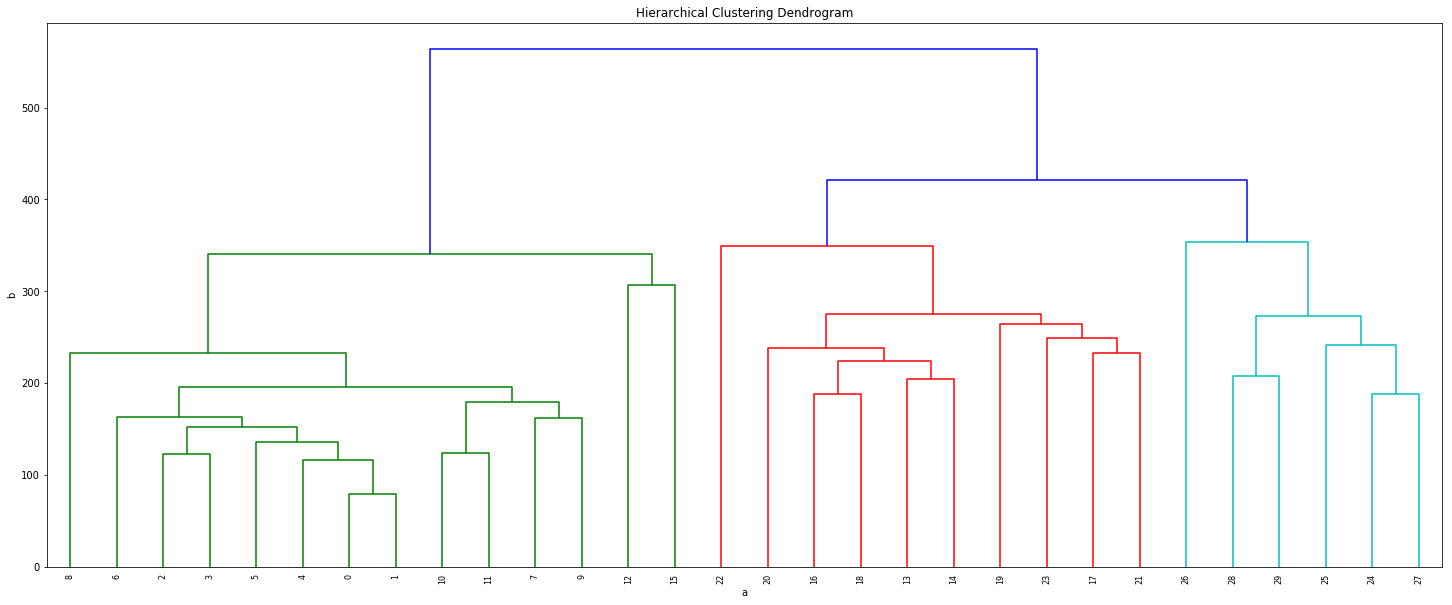

In [10]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('a')
plt.ylabel('b')

dendrogram(
linkage(model.clusterCenters, method='complete'),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=k,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [56]:
import csv, io

def list_to_csv_str(x):
    """Given a list of strings, returns a properly-csv-formatted string."""
    output = io.StringIO("")
    csv.writer(output).writerow(x)
    return output.getvalue().strip() # remove extra newline

# ... do stuff with your rdd ...
rdd = normalised_hotels_prices.map(lambda x: [x[0]] + x[1]).map(list_to_csv_str)
rdd.saveAsTextFile("output_directory")

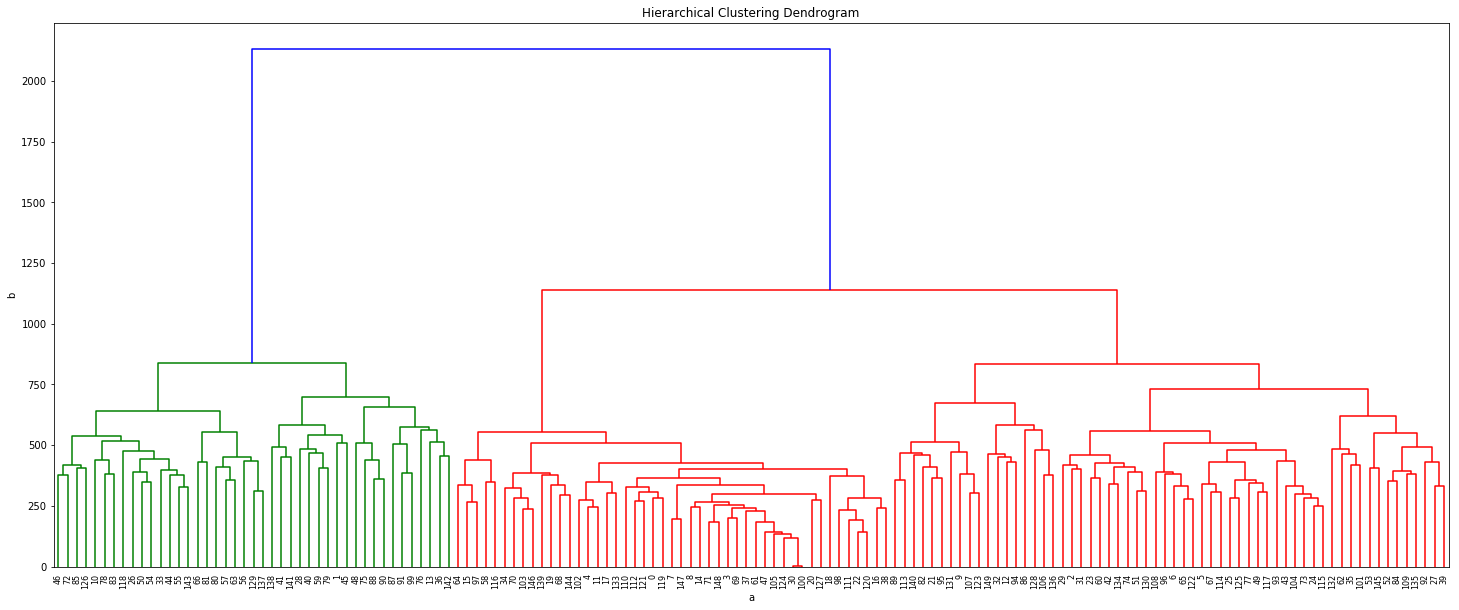

In [44]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('a')
plt.ylabel('b')

Z = linkage(normalised_prices.take(hotels_num), 'ward')

dendrogram(Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=hotels_num,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [8]:
normalised_prices.take(1)

[[-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  9.47176684881603,
  10.018214936247723,
  0.0,
  -1,
  -1,
  -1,
  -1,
  14.025500910746812,
  14.025500910746812,
  14.025500910746812,
  14.025500910746812,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  24.043715846994534,
  32.05828779599271,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  51.7304189435337,
  61.56648451730419,
  71.5846994535519,
  -1,
  -1,
  53.916211293260474,
  -1,
  71.5846994535519,
  -1,
  32.05828779599271,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  45.90163934426229,
  -1,
  34.06193078324226,
  -1,
  47.540983606557376,
  -1,
  -1,
  -1,
  43.169398907103826,
  -1,
  -1,
  42.25865209471767,
  -1,
  -1,
  100.0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  82.87795992714025,
  -1,
  -1,
  -1,
  21.493624772313296,
  -1,
  -1,
  -1,
  59.92714025500911,
  -1,
  -1,
  -1,
  -1,
  -1,
